# Notebook 4: Machine Learning Modeling of Milling Process Data

In the previous notebook, we performed a **correlation analysis** to explore relationships between process signals such as currents, forces, and cutting parameters.

---

## Data Splitting and Test Sets

After cleaning and preprocessing, a total of **40 out of 43 conducted experiments** were combined into a single dataset. This dataset was then split into:

- **70% Training set (`df_Train`)**  
- **15% Validation set (`df_Val`)**  
- **15% Test set 1 (`df_Test`)**

In addition to this, **one experiment** was **not included** in the main dataset. Instead, it was kept separate as a **second dedicated test set** (`df_Test_D6D6D8`).

### Purpose of the Two Test Sets:

- **Test Set 1** (`df_Test`):  
  Contains smaller segments from multiple experiments.  
  → Used to evaluate model performance under **varying tool diameters**.

- **Test Set 2** (`df_Test_D6D6D8`):  
  Consists of an **entire, previously unseen experiment**.  
  → Used to assess the model's **generalization capability on full process trials**.

This dual test set approach allows for both **fine-grained** and **realistic** model evaluation.

---

## Goal of this Notebook

In this notebook, we will develop and evaluate a **machine learning model** — specifically, a **Random Forest Regressor** — to **predict the spindle current** (`ACT_CURRENT_S`) based on process data.

### Key objectives:

- Train the model using the training set (`df_Train`)  
- Tune and validate the model using the validation set (`df_Val`)  
- Evaluate the model on:
  - **Test Set 1** for typical predictive performance
  - **Test Set 2** for generalization on entire experiments  
- Use metrics such as:
  - **R² Score**
  - **Root Mean Squared Error (RMSE)**
  - **Mean Absolute Error (MAE)**
- Analyze **feature importance** to interpret which process signals contribute most to the spindle current prediction

This notebook links **machine learning techniques** with **domain-specific knowledge** from the milling process and supports **data-driven process optimization**.


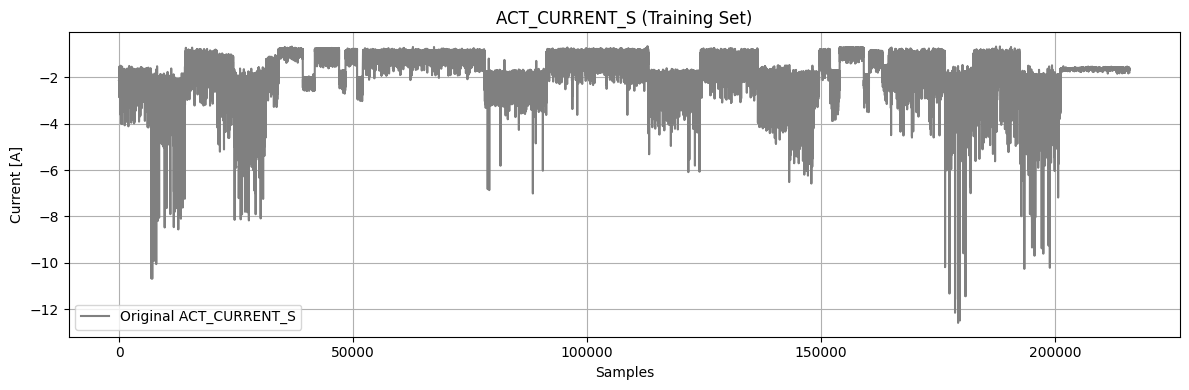

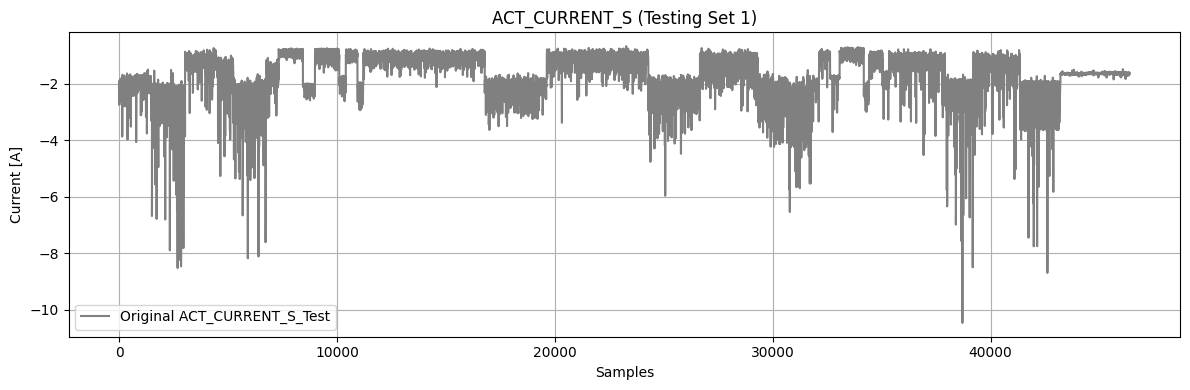

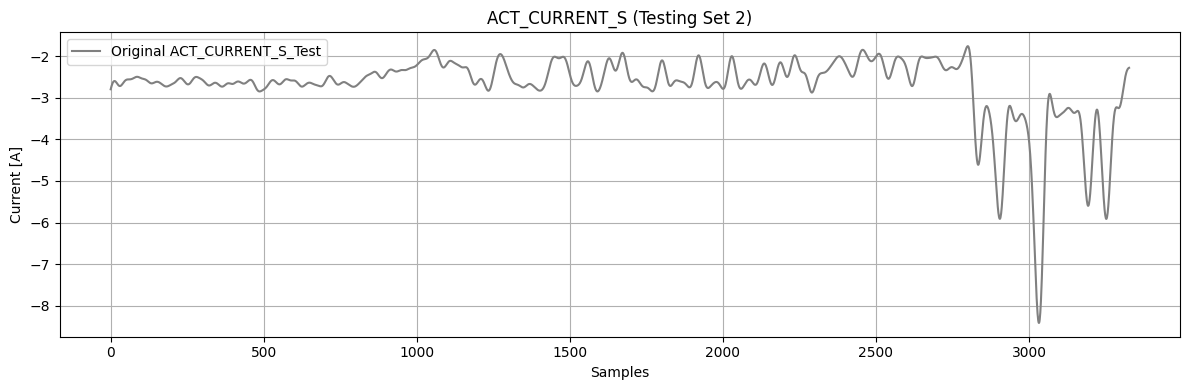

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

files = sorted(glob.glob("Rough_Train_New*.csv.gz"))
dfs = [pd.read_csv(f, compression="gzip") for f in files]
df_Train = pd.concat(dfs, ignore_index=True)
df_Test = pd.read_csv("Rough_Test_New.csv.gz", compression="gzip")
df_Test_2 = pd.read_csv("Rough_Test_D6D6D8.csv.gz", compression="gzip")
df_Val = pd.read_csv("Rough_Val_New.csv.gz", compression="gzip")

# Filter test data to include only specific experiment labels
labels_to_keep = ['25_D6_Al_Rough_1'] 
df_Test_2 = df_Test_2[df_Test_2['Experiment_Label'].isin(labels_to_keep)]

# Plot: Spindle current Training set
plt.figure(figsize=(12, 4))
plt.plot(df_Train['ACT_CURRENT_S'], color='gray', label='Original ACT_CURRENT_S')
plt.title('ACT_CURRENT_S (Training Set)')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Spindle current Test set 1
plt.figure(figsize=(12, 4))
plt.plot(df_Test['ACT_CURRENT_S'], color='gray', label='Original ACT_CURRENT_S_Test')
plt.title('ACT_CURRENT_S (Testing Set 1)')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Spindle current Test set 2
plt.figure(figsize=(12, 4))
plt.plot(df_Test_2['ACT_CURRENT_S'], color='gray', label='Original ACT_CURRENT_S_Test')
plt.title('ACT_CURRENT_S (Testing Set 2)')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



## Feature and Target Distribution Alignment

During the data splitting process, special care was taken to ensure that the **distributions of both the features and the target variables** in the training, validation, and test sets remained consistent with those in the **original full dataset**.

This was achieved by preserving a **similar proportion of data from all experiments** across each subset. This approach helps to avoid bias and ensures that the model is trained and evaluated on data that reflects the **full range of process conditions**.

Below, we visualize the distribution of selected features and target variables across the training, validation, and test sets to confirm this alignment.

The distributions of **spindle speed**, **width of cut (ae)**, **cutting speed**, and **spindle current** are consistent across all three subsets.  
The plots illustrate that the data was split in a **balanced and representative manner**, ensuring the reliability of the model's training and evaluation process.


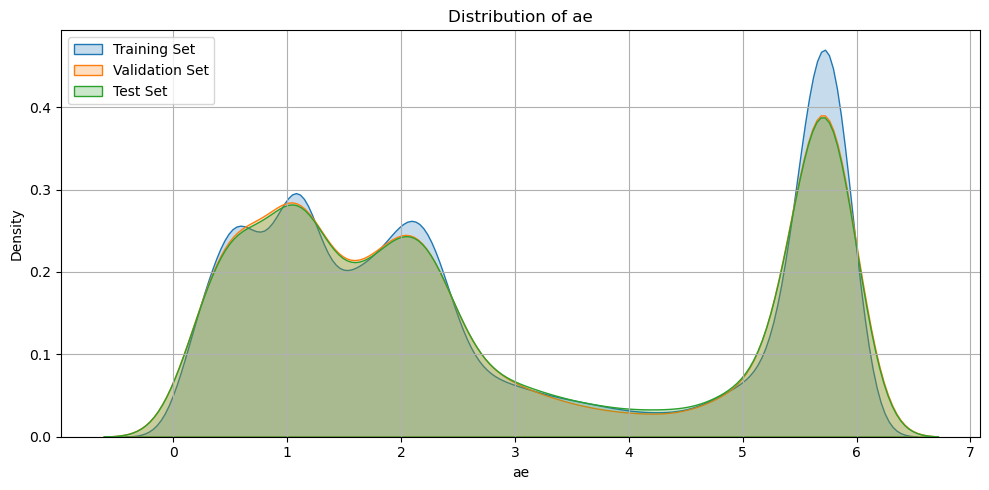

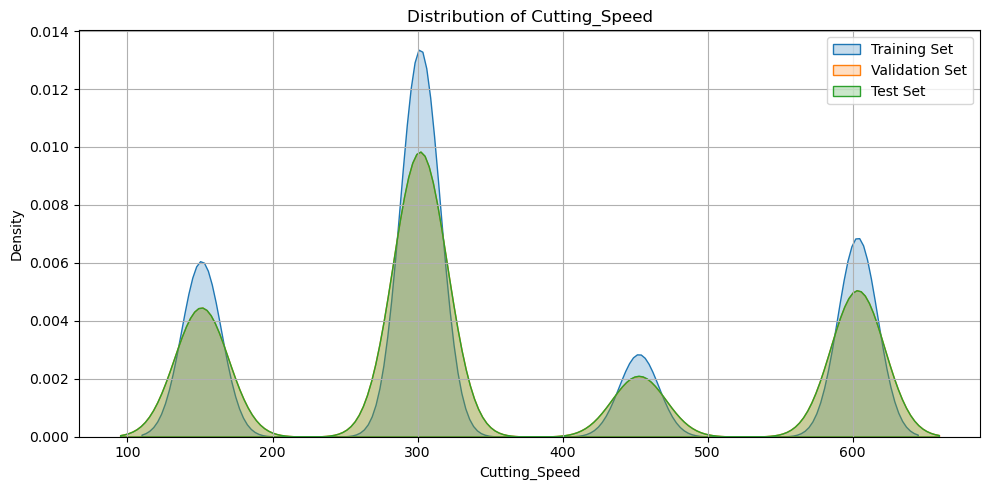

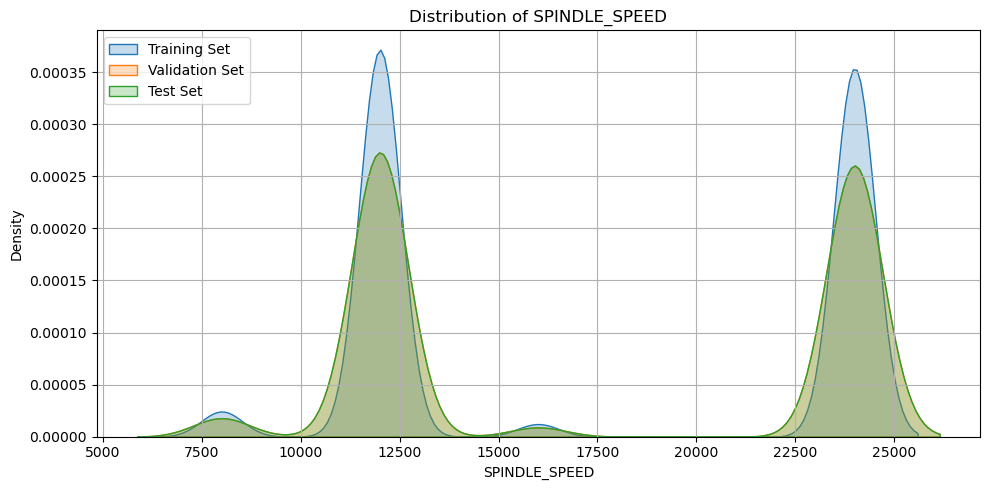

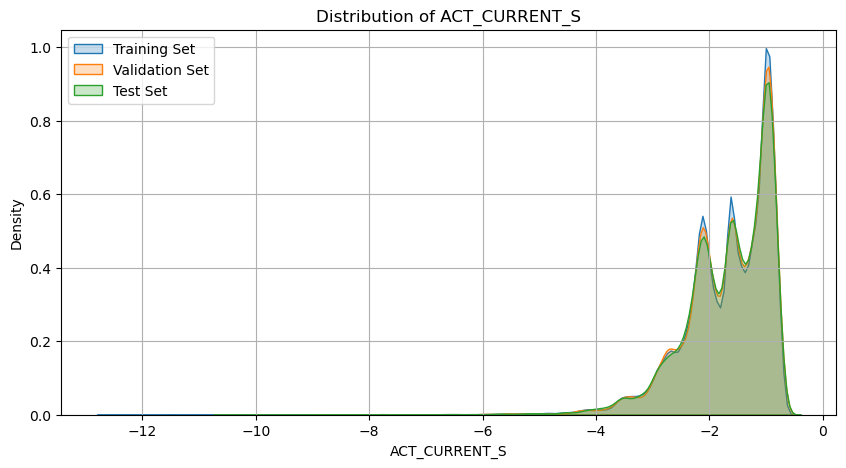

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a list of selected input features to visualize
selected_features = ['ae', 'Cutting_Speed', 'SPINDLE_SPEED']

# Plot the distribution of each selected feature for Train, Validation, and Test sets
for feature in selected_features:
    plt.figure(figsize=(10, 5))
    
    # Kernel Density Estimation (KDE) plot for each dataset
    sns.kdeplot(df_Train[feature], label='Training Set', fill=True)
    sns.kdeplot(df_Val[feature], label='Validation Set', fill=True)
    sns.kdeplot(df_Test[feature], label='Test Set', fill=True)
    
    # Plot styling
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# Define a list of target variables (here only the spindle current)
target_variables = ['ACT_CURRENT_S']

# Plot the distribution of the target variable for Train, Validation, and Test sets
for target in target_variables:
    plt.figure(figsize=(10, 5))
    
    sns.kdeplot(df_Train[target], label='Training Set', fill=True)
    sns.kdeplot(df_Val[target], label='Validation Set', fill=True)
    sns.kdeplot(df_Test[target], label='Test Set', fill=True)
    
    plt.title(f'Distribution of {target}')
    plt.xlabel(target)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
plt.show()


# Exercise: Spindle Current Prediction using Random Forest

## Task Description:

In this exercise, you will build a **regression model** to predict the **spindle current** (`ACT_CURRENT_S`) based on selected process parameters from a milling process.

Your task is to:

1. **Train a Random Forest Regressor** using the provided training data (`df_Train`).
2. **Evaluate the model** on two separate test sets:
   - `df_Test` (Test Set 1 – partial runs)
   - `df_Test_2` (Test Set 2 – full unseen experiment)
3. **Visualize** the results using two types of plots:
   - Time-series plot: actual vs predicted current
   - Scatter plot with regression fit and perfect diagonal
4. **Analyze feature importance** to understand which process parameters most influence the prediction.

---

## Instructions and Hints:

### 1. Data Preparation
- Use the following **target variable**:
  - `ACT_CURRENT_S`
- Use the following **features** for training:
  ```python
  [
      'ACTIVE_TOOL_LENGTH', 'SPINDLE_SPEED', 'Fz_N', 'Fy_N', 'Fx_N',
      'MultiDexel:GridX-EngagementHeight', 'MultiDexel:GridY-EngagementHeight',
      'MultiDexel:GridZ-EngagementHeight', 'Tool_Diameter', 'Feed_Rate',
      'Feed_per_Tooth', 'Cutting_Speed', 'ae', 'Qw', 'F_xyz'
  ]
- Use the following pre-tuned hyperparameters for the Random Forest model
```python
    {
        'n_estimators': 239,
        'max_depth': 59,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt'
    }

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import time


# Ensure consistent plots
sns.set(style="whitegrid")

# Check for overlap between training and test data
overlap = pd.merge(df_Train, df_Test, how='inner')  # Inner join to find overlapping rows
if not overlap.empty:
    print("There is overlap between training and test data! Review the overlapping rows.")
    print(overlap)
else:
    print("No overlap between training and test data.")

# Define the target variable and feature list
target_variables = ['ACT_CURRENT_S']
features = [
    'ACTIVE_TOOL_LENGTH', 'SPINDLE_SPEED', 'Fz_N', 'Fy_N', 'Fx_N',
    'MultiDexel:GridX-EngagementHeight', 'MultiDexel:GridY-EngagementHeight', 
    'MultiDexel:GridZ-EngagementHeight', 'Tool_Diameter', 'Feed_Rate', 
    'Feed_per_Tooth', 'Cutting_Speed', 'ae', 'Qw', 'F_xyz'
]

# Best hyperparameters from previous tuning
best_params = {
    'n_estimators': 239,
    'max_depth': 59,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

# Dictionary to store feature importances
feature_importance_dict = {}

# Test sets to evaluate
test_sets = {
    "Test Set 1": df_Test,
    "Test Set 2": df_Test_2
}

# Training data
X_train = df_Train[features]
y_train = df_Train['ACT_CURRENT_S']


